# Entraînement des modèles de classification

## 1 - Manipulation et preprocessing des données

On définit une classe pour manipuler le dataset d'images de HappyBud.

In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms_v2
from PIL import Image
import pathlib

class HappyBudDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, subset="train", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file.
            root_dir (str): Root directory containing train, val, and test folders.
            subset (str): One of 'train', 'val', or 'test'.
            transform (callable, optional): Transformations to apply to images.
        """
        self.df = pd.read_csv(
            csv_file,
            index_col=0,
            dtype={
                "filename": str,
                "source": "category",
                "subset": "category",
                "class": "category",
            }
        )

        # Filter dataset based on 'train', 'val', or 'test'
        self.df = self.df[self.df["subset"] == subset]

        # One-hot encoding of labels
        self.labels = pd.get_dummies(self.df["class"])

        self.root_dir = pathlib.Path(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_name = self.df["filename"].iloc[idx]
        img_path = self.root_dir / img_name

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Load labels (convert to tensor)
        labels = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float32)

        return image, labels

# Define transformations
transform = transforms_v2.Compose(
    [
        transforms_v2.ToImage(),    # Convert to image tensor
        transforms_v2.ToDtype(torch.float32, scale=True), # Convert dtype to float32
        transforms_v2.Resize((224, 224)),  # Resize images to match model input
    ]
)

# Create dataset
csv_path = "dataset/tomato_dataset_clean_split.csv"
root_dir = "dataset/tomato/"

train_dataset = HappyBudDataset(csv_path, root_dir, subset="train", transform=transform)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test the dataset
for images, labels in train_loader:
    print(images.shape)  # Should be (batch_size, 3, 224, 224)
    print(labels.shape)  # Should be (batch_size, num_classes)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32, 11])


On définit un pipeline pour l'entraînement des données. Ce pipeline se base sur cette
[page](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html)
qui définit les bonnes pratiques pour différentes tâches de vision. On se base aussi en
partie sur le [pipeline](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights)
qui a été utilisé pour entraîner le modèle sur ImageNet1K.

Voici les étapes du pipeline:
- Conversion en tenseur
- Changement du type de données pour float32
- Redimensionnement en images 256x256 (légèrement plus gros que l'entrée)
- Rotation aléatoire
- Réflexion horizontale aléatoire
- Recadrage (crop) aléatoire en 224x224
- Normalisation selon la moyenne et l'écart type de ImageNet1K

In [27]:
# Training pipeline
transformations = [
    # Conversion to float32 image tensor
    transforms_v2.ToImage(),
    transforms_v2.ToDtype(torch.float32, scale=True),
    # Data augmentation
    transforms_v2.Resize((256, 256), antialias=True),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.RandomRotation(degrees=(0, 360)),#, interpolation=transforms_v2.InterpolationMode.BILINEAR),
    transforms_v2.RandomCrop(size=(224, 224)),
    # Normalization for ViT, valeurs de ImageNet1K
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

training_pipeline = transforms_v2.Compose(transformations)

# Pour l'affichage des images, on ne doit pas normaliser
dummy_pipeline = transforms_v2.Compose(transformations[:-1])

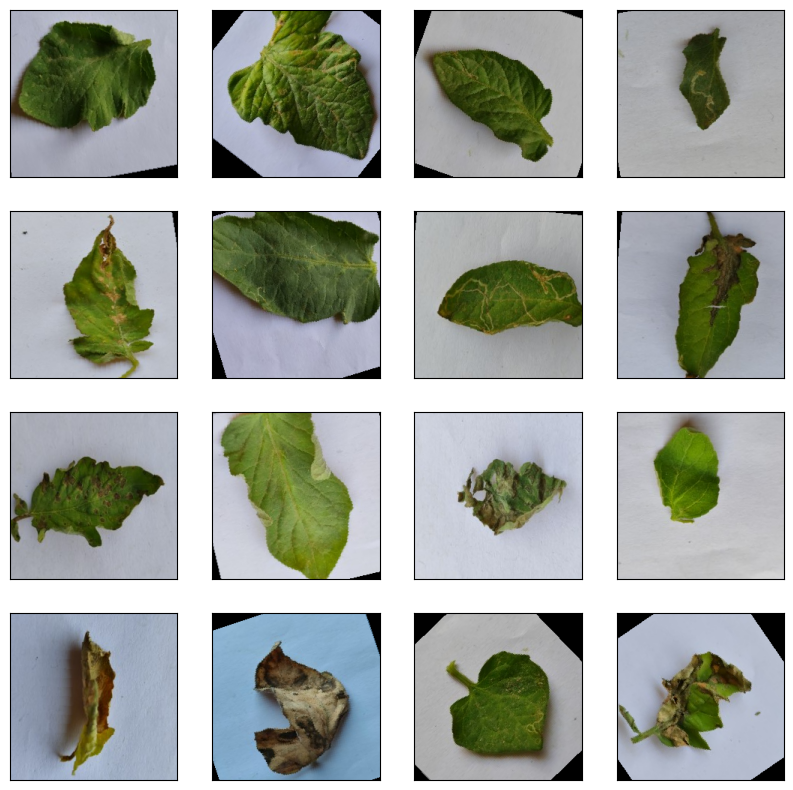

In [31]:
# Visualisation de quelques images après passage du pipeline
import matplotlib.pyplot as plt

dummy_train_dataset = HappyBudDataset(csv_path, root_dir, subset="train", transform=dummy_pipeline)
dummy_train_loader = DataLoader(dummy_train_dataset, batch_size=16, shuffle=True)

images, labels = next(iter(dummy_train_loader))

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for i, image in enumerate(images):
    ax = axes.flatten()[i]
    ax.imshow(image.moveaxis(0, -1))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

In [32]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
#import timm
from torchvision.models import vit_b_16


In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize for ViT
])
# Create dataset
csv_path = "dataset/tomato_dataset_clean_split.csv"
root_dir = "dataset/tomato/"

# Load datasets
train_dataset = HappyBudDataset(csv_file=csv_path, root_dir=root_dir, subset="train", transform=transform)
test_dataset = HappyBudDataset(csv_file=csv_path, root_dir=root_dir, subset="test", transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
# Load pretrained ViT
num_labels = len(train_dataset.label_columns)  # Get number of labels (e.g., 8)

model = vit_b_16(weights="IMAGENET1K_V1")  # Load a pretrained model
model.heads.head = nn.Linear(model.heads.head.in_features, num_labels)  # Modify last layer


In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Loss function & optimizer
criterion = nn.BCEWithLogitsLoss()  # Suitable for multilabel classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
# Training function
#def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0.0

        for images, labels in train_loader:
            # Compute loss
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # Logits
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Compute number of correct images
            predictions = (outputs > 0.7).int()
            correct += (predictions == labels).all(axis=1).sum()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / len(train_loader.dataset)

        # Validation phase
        #model.eval()
        #val_loss = 0.0
        #with torch.no_grad():
        #    for images, labels in val_loader:
        #        images, labels = images.to(device), labels.to(device)
        #        outputs = model(images)
        #        loss = criterion(outputs, labels)
        #        val_loss += loss.item()

        #avg_val_loss = val_loss / len(val_loader)

        #print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")

# Train for 10 epochs
#train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)
train_model(model, train_loader, criterion, optimizer, epochs=10)


In [ ]:
# Save model
torch.save(model.state_dict(), "tomato_model_2025_02_25.pt")

In [ ]:
import sklearn
import numpy as np
import pandas as pd

# Fonction pour le calcul de la matrice de confusion
def compute_confusion_matrix(y_true, y_pred, classes, abreviations=None):
    """Compute the confusion matrix and performance metrics

    This function computes the confusion matrix and performance measures such as
    recall, precision and accuracy. The confusion matrix and the performance metrics
    are written in a pandas DataFrame.

    Parameters
    ----------
    y_true : numpy.ndarray
        Array containing the true numeric classes from the data.
    y_pred : numpy.ndarray
        Array containing the predicted numeric classes by the model.
    classes : list, numpy.ndarray
        List of labels for the classes of the data.capitalize
    abreviations : list, numpy.ndarray, default: None
        List of abreviations for the classes to use as table columns. If None, use the
        classes also for the columns.
    
    Returns
    -------
    pandas.DataFrame
        Dataframe containing the confusion matrix and performance metrics.
        
    """
    if abreviations is None:
        abreviations = classes
    
    # Compute confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

    # Diagonal range index
    idx = np.arange(confusion_matrix.shape[0])

    # Recall
    recall = confusion_matrix[idx, idx] / confusion_matrix.sum(axis=1)

    # Precision
    precision = confusion_matrix[idx, idx] / confusion_matrix.sum(axis=0)

    # Accuracy
    accuracy = confusion_matrix[idx, idx].sum() / confusion_matrix.sum()

    # Creating dataframe
    columns = list(abreviations) + ["Recall"]
    rows = list(classes) + ["Precision"]
    df = pd.DataFrame(np.nan, index=rows, columns=columns)
    df.loc[classes, abreviations] = confusion_matrix
    df.loc[classes, "Recall"] = recall
    df.loc["Precision", abreviations] = precision
    df.loc["Precision", "Recall"] = accuracy

    return df


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour l'affichage de la matrice de confusion
def display_confusion_matrix(confusion_matrix, origin="upper", title=None):
    """Display the confusion matrix in a matplotlib figure
    
    This function uses matplotlib to display the confusion matrix with the
    :func:`matplotlib.pyplot.imshow` function.

    Parameters
    ----------
    confusion_matrix : pandas.DataFrame
        Dataframe containing the confusion matrix and the performance metrics such as
        recall, precision and accuracy. The `confusion_matrix` is generally returned
        from the `compute_confusion_matrix` function of this notebook.

    origin : {'upper', 'lower'}, default: 'upper'
        Whether to display the confusion matrix using a upper left origin or a lower
        left origin.

    Returns
    -------
    matplotlib.figure.Figure
        The matplotlib figure object that is created using this function

    """
    classes = confusion_matrix.columns[:-1]

    fig, ax = plt.subplots(figsize=(7, 7), layout="constrained")

    if origin == "upper":
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    img = ax.imshow(
        confusion_matrix.values[:-1, :-1], cmap="Blues", origin=origin, vmin=0
    )

    ax.set_yticks(np.arange(len(classes)), labels=classes)
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)

    # Adding labels
    ax.set_ylabel("True class", size=16)
    ax.set_xlabel("Predicted class", size=16)

    # Adding test
    for i in range(len(classes)):
        for j in range(len(classes)):
            value = confusion_matrix.values[i, j]
            vmax = img.get_clim()[1]
            color = "w" if value > 0.5 * vmax else "k"
            ax.text(
                j,
                i,
                f"{value:0.0f}",
                ha="center",
                va="center",
                color=color,
            )

    # Adding precision and recall
    for i in range(len(classes)):
        # Precision
        ax.text(
            -0.7,
            len(classes),
            "PRECISION",
            ha="right",
            va="center",
            color="k",
            fontweight="bold"
        )
        
        ax.text(
            i,
            len(classes),
            f"{100*confusion_matrix.iloc[-1, i]:0.1f} %",
            ha="center",
            va="center",
            color="k",
        )

        # Recall
        ax.text(
            len(classes),
            -0.7, "RECALL",
            ha="center",
            va="bottom" if origin == "upper" else "top",
            color="k",
            rotation=90,
            fontweight="bold",
        )

        ax.text(
            len(classes),
            i,
            f"{100*confusion_matrix.iloc[i, -1]:0.1f} %",
            ha="center",
            va="center",
            color="k",
        )
        
        # Accuracy
        ax.text(
            len(classes),
            len(classes),
            f"{100*confusion_matrix.iloc[-1,-1]:0.1f} %",
            ha="center",
            va="center",
            color="k",
            fontweight="bold",
        )
    
    # Set title
    if title is not None:
        fig.suptitle(title, fontsize=18, fontweight="bold")

    return fig

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, test_loader, class_names):
    model.eval()  # Set to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No gradients needed
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds = (outputs > 0.7).int()  # Convert probabilities to binary (0 or 1)

            all_labels.append(labels.cpu().numpy())  # Store true labels
            all_preds.append(preds.cpu().numpy())  # Store predictions

    # Convert lists to numpy arrays
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    # Compute metrics for each class
    metrics = {}
    for i, class_name in enumerate(class_names):
        acc = accuracy_score(all_labels[:, i], all_preds[:, i])
        precision = precision_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        recall = recall_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        f1 = f1_score(all_labels[:, i], all_preds[:, i], zero_division=0)

        metrics[class_name] = {
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
        }

    return metrics

# Define class names (based on CSV headers)
class_names = ["Early blight", "Healthy", "Late blight", "Leaf Miner", 
               "Magnesium Deficiency", "Nitrogen Deficiency", 
               "Potassium Deficiency", "Spotted Wilt Virus"]

# Evaluate model
metrics = evaluate_model(model, test_loader, class_names)

# Print results
for category, scores in metrics.items():
    print(f"\nCategory: {category}")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")
